<a href="https://colab.research.google.com/github/Sruthij93/Market-Anomaly-Detection/blob/main/Market_Anomaly_Milestone2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import pickle
import shap
import pickle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import IsolationForest
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [3]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [4]:
!git clone https://github.com/Sruthij93/Market-Anomaly-Detection

Cloning into 'Market-Anomaly-Detection'...
remote: Enumerating objects: 113, done.
remote: Counting objects: 100% (113/113), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 113 (delta 55), reused 58 (delta 20), pack-reused 0 (from 0)
Receiving objects: 100% (113/113), 10.54 MiB | 10.86 MiB/s, done.
Resolving deltas: 100% (55/55), done.


In [5]:
%cd /content/Market-Anomaly-Detection

/content/Market-Anomaly-Detection


In [6]:
sim_data = pd.read_csv('/content/Market-Anomaly-Detection/sim_financial_data.csv')

In [7]:
sim_data.shape

(1097, 15)

In [8]:
# Clean the test data and conduct preprocessing

def data_cleaning(test_df):

  model_features = ['XAU BGNL', 'BDIY', 'CRY', 'DXY', 'VIX', 'USGG30YR', 'GT10', 'EONIA', 'GTITL30YR', 'GTJPY30YR', 'LP01TREU', 'MXUS', 'MXEU', 'MXIN']
  # 'GC=F', ^VIX, ^TYX, ^XDE,

  # Drop any extra columns not in the model features
  test_df = test_df.loc[:, test_df.columns.intersection(model_features)]


  # Add missing columns with default value
  missing_columns = [col for col in model_features if col not in test_df.columns]

  for col in missing_columns:
      test_df[col] = 0

  # Reorder columns to match model's feature order
  test_df = test_df[model_features]

  # Remove the date column
  if 'Date' in test_df.columns:
    test_df = test_df.drop(columns = ['Date'])

  # Add additional columns of moving averages and simple moving averages
  test_df['VIX_EMA'] = test_df['VIX'].ewm(span=50, adjust=False).mean()
  test_df['BDIY_EMA'] = test_df['BDIY'].ewm(span=50, adjust=False).mean()
  test_df['DXY_EMA'] = test_df['DXY'].ewm(span=50, adjust=False).mean()
  test_df['VIX_MA'] = test_df['VIX'].rolling(window=50).mean()
  test_df['BDIY_MA'] = test_df['BDIY'].rolling(window=50).mean()

  test_df['VIX_MA'] = test_df['VIX_MA'].fillna(test_df['VIX'])
  test_df['BDIY_MA'] = test_df['BDIY_MA'].fillna(test_df['BDIY'])

  return test_df


def data_preprocessing(test_df, model):

  test_df = data_cleaning(test_df)

  # Load the scaler saved in pickle file
  with open('/content/Market-Anomaly-Detection/data_preprocessors/scaler.pkl', 'rb') as file:
    scaler = pickle.load(file)

  # Scale the data
  test_df_scaled = scaler.fit_transform(test_df)

  if model == 'isolation_forest':
    # Load the PCA saved in pickle file
    with open('/content/Market-Anomaly-Detection/data_preprocessors/pca_isoforest.pkl', 'rb') as file:
      pca = pickle.load(file)
  else:
    # Load PCA
    with open('/content/Market-Anomaly-Detection/data_preprocessors/pca.pkl', 'rb') as file:
      pca = pickle.load(file)

  # Apply PCA
  test_df_pca = pca.transform(test_df_scaled)

  # Adding raw features(scaled) for better performance
  test_df_columns = {name: index for index, name in enumerate(test_df.columns)}
  selected_columns = ['VIX', 'VIX_EMA', 'BDIY_EMA', 'DXY_EMA', 'VIX_MA', 'BDIY_MA']
  selected_columns_indices = [test_df_columns[col] for col in selected_columns]

  test_set = np.hstack((test_df_pca, test_df_scaled[:, selected_columns_indices]))

  return test_set




In [9]:
# Test the Isolation Forest model
# sim_data = sim_data.to_frame().T
test_df = data_preprocessing(sim_data, 'isolation_forest')

with open('/content/Market-Anomaly-Detection/trained_models/isoforest_model.pkl', 'rb') as file:
  isoforest_model = pickle.load(file)

isoforest_predictions = isoforest_model.predict(test_df)

# Print the anomaly score for each row and add anomaly label column to a copy of test_df
isoforest_scores = isoforest_model.score_samples(test_df)
data_copy = sim_data.copy()
data_copy['isoforest_predictions'] = isoforest_scores
data_copy['Anomaly_ISO'] = isoforest_predictions > 0
data_copy['Anomaly_ISO'] = data_copy['Anomaly_ISO'].astype(int)


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.2 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.5.2 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator ExtraTreeRegressor from version 1.5.2 when using version 1.6.0. This might lead to breaking code or invalid

In [10]:
data_copy.shape

(1097, 17)

In [11]:
data_copy['Anomaly_ISO'].value_counts()

Anomaly_ISO
1    616
0    481
Name: count, dtype: int64

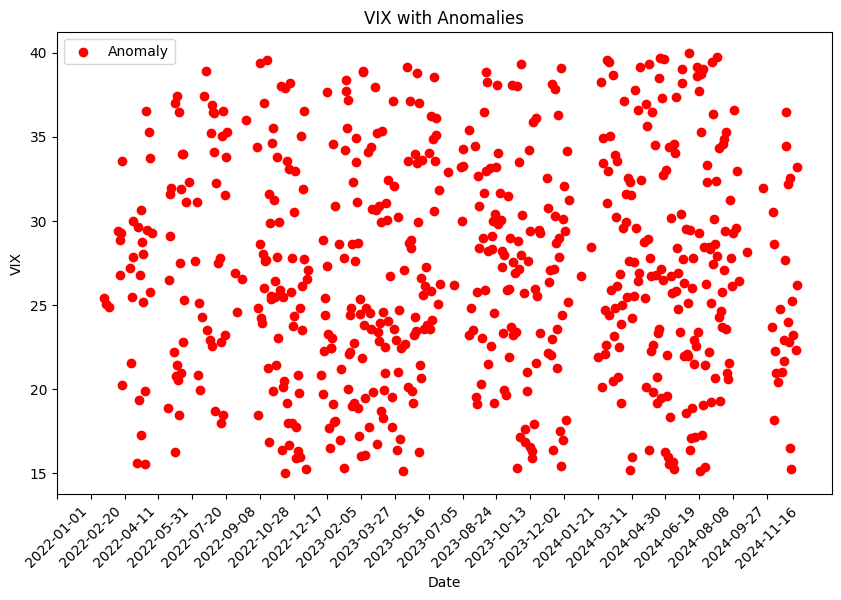

In [12]:
# plot the anomalies along VIX
plt.figure(figsize=(10, 6))
plt.scatter(data_copy[data_copy['Anomaly_ISO'] == 1].index, data_copy[data_copy['Anomaly_ISO'] == 1]['VIX'], color='red', label='Anomaly')
plt.xticks(range(0, data_copy.shape[0], 50), data_copy['Date'].iloc[::50], rotation = 45)
plt.xlabel('Date')
plt.ylabel('VIX')
plt.title('VIX with Anomalies')
plt.legend()
plt.show()

In [13]:
# Test the SVM model
with open('/content/Market-Anomaly-Detection/trained_models/svm_model.pkl', 'rb') as file:
  svm_model = pickle.load(file)

test_df = data_preprocessing(sim_data, 'svm')
svm_predictions = svm_model.predict(test_df)


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.5.2 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.2 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.5.2 when using version 1.6.0. This might lead to breaking code or invalid results. Use a

In [14]:
# Test the Voting classifier model
with open('/content/Market-Anomaly-Detection/trained_models/voting_clf_model.pkl', 'rb') as file:
  voting_clf = pickle.load(file)

test_df = data_preprocessing(sim_data, 'voting')
voting_predictions = voting_clf.predict(test_df)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.2 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.2 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.5.2 when using version 1.6.0. This might lead to breaking cod

In [15]:
voting_predictions= voting_predictions.reshape(-1,1)

## Strategies
- Buy options when VIX is low and sell options when VIX is high
- If the DXY indicates an uptrend in value, it is best to buy the USD against other currencies. If the USD is going through a downtrend, it is time to sell the USD against another, stronger currency.
- During an anomaly:
  - Market Crash:
    * Shift to safe-haven markets like gold, US Treasury bonds, or defensive stocks (utilities, healthcare)
    * Avoid panic selling- hold quality stocks if you believe in their long term potential
  - Volatality Spike (high VIX)
    * sell options if you are experienced, as high volality inflates their premiums
    * Conservative: reduce equity exposure and increase cash or bonds
    * dont buy volatile stocks, as prices swing wildly.
  - Currency Anomalies (USD spike or crash)
    * USD Uptrend: invest in USD denominated assets or exporting companies
    * USD Downtrend: explore assets like gold or foreign stocks that could benefit from a weaker dollar
- During calm markets or no anomalies:
  - Diversify Portfolio
  - Use Dollar Cost Averaging (DCA) eg: invest $500 monthly in S&P 500 index fund
  - Rebalance your Portfolio:
    * if stocks outperform bonds, rebalance by selling some stocks and buying more bonds
  - Invest in Growth Opportunities


## Next Steps
- create a strategy column for the test data
- check if it matches the anomaly indicator
- Feed in the results - test data, with predictions to an LLM and ask it to verify


In [58]:
# JSON Object with all the strategies as context to feed into an LLM

strategies = {
  "investment_rules": [
    {
      "feature": "XAU_BGNL",
      "description": "Gold Prices",
      "signals": [
        {
          "condition": "VIX > 25 OR DXY < 90",
          "action": "Increase exposure to gold as a safe-haven asset."
        },
        {
          "condition": "DXY > 100 AND USGG30YR > 3%",
          "action": "Reduce exposure to gold due to rising dollar strength and interest rates."
        }
      ]
    },
    {
      "feature": "BDIY",
      "description": "Baltic Dry Index (Global Trade Health)",
      "signals": [
        {
          "condition": "BDIY trending upwards",
          "action": "Invest in cyclical sectors (e.g., industrials, energy, commodities)."
        },
        {
          "condition": "BDIY consistently declining",
          "action": "Reduce exposure to cyclical stocks; consider defensive assets."
        }
      ]
    },
    {
      "feature": "CRY",
      "description": "Core Commodity CRB Excess Return Index",
      "signals": [
        {
          "condition": "CRY trending upwards",
          "action": "Invest in commodity-focused ETFs or inflation-hedging assets like energy and agriculture."
        },
        {
          "condition": "CRY trending downwards",
          "action": "Shift investments to defensive sectors or government bonds."
        }
      ]
    },
    {
      "feature": "DXY",
      "description": "US Dollar Index",
      "signals": [
        {
          "condition": "DXY weakening",
          "action": "Invest in international equities (e.g., MXEU, MXIN) or commodities like gold and oil."
        },
        {
          "condition": "DXY strengthening",
          "action": "Reduce exposure to emerging market equities and commodities, which may underperform."
        }
      ]
    },
    {
      "feature": "VIX",
      "description": "Volatility Index (Fear Index)",
      "signals": [
        {
          "condition": "VIX is low",
          "action": "Focus on growth-oriented stocks or riskier assets."
        },
        {
          "condition": "VIX is spiking and anomalies are detected",
          "action": "Reduce risk by increasing allocations to bonds or cash."
        }
      ]
    },
    {
      "feature": "USGG30YR",
      "description": "US 30-Year Government Bonds",
      "signals": [
        {
          "condition": "USGG30YR yields falling",
          "action": "Increase allocation to growth stocks and bonds as lower yields are favorable."
        },
        {
          "condition": "USGG30YR yields rising",
          "action": "Shift to inflation-protected assets or shorter-duration bonds to minimize risk."
        }
      ]
    },
    {
      "feature": "GT10",
      "description": "US 10-Year Treasury Yield",
      "signals": [
        {
          "condition": "GT10 yields falling",
          "action": "Invest in long-term bonds and growth-oriented stocks."
        },
        {
          "condition": "GT10 yields rising",
          "action": "Shift to value stocks or shorter-duration bonds to hedge against interest rate risk."
        }
      ]
    },
    {
      "feature": "EONIA",
      "description": "Euro Overnight Index Average",
      "signals": [
        {
          "condition": "EONIA falling",
          "action": "Invest in European equities or longer-duration bonds due to dovish ECB policy."
        },
        {
          "condition": "EONIA rising",
          "action": "Reduce exposure to equities and longer-duration bonds in the Eurozone."
        }
      ]
    },
    {
      "feature": "GTITL30YR",
      "description": "Italian Government 30-Year Bonds",
      "signals": [
        {
          "condition": "GTITL30YR yields falling",
          "action": "Increase allocation to safe-haven assets like gold or high-grade bonds."
        },
        {
          "condition": "GTITL30YR yields rising",
          "action": "Consider investing in equities or risk-on assets, indicating improving economic conditions."
        }
      ]
    },
    {
      "feature": "GTJPY30YR",
      "description": "Japanese Government 30-Year Bonds",
      "signals": [
        {
          "condition": "GTJPY30YR yields falling",
          "action": "Shift to safe-haven assets like gold or government bonds in stable economies."
        },
        {
          "condition": "GTJPY30YR yields rising",
          "action": "Consider equities or risk-on assets, indicating potential growth."
        }
      ]
    },
    {
      "feature": "LP01TREU",
      "description": "Pan Euro High Yield Index",
      "signals": [
        {
          "condition": "LP01TREU rising",
          "action": "Invest in European equities and high-yield bonds, signaling improved credit conditions."
        },
        {
          "condition": "LP01TREU falling",
          "action": "Reduce exposure to high-yield bonds and riskier European assets due to tighter credit."
        }
      ]
    },
    {
      "feature": "MXUS",
      "description": "US Equity Index",
      "signals": [
        {
          "condition": "MXUS trending upwards",
          "action": "Increase exposure to US equities for potential growth opportunities."
        },
        {
          "condition": "MXUS trending downwards",
          "action": "Reduce exposure to US equities; consider defensive assets."
        }
      ]
    },
    {
      "feature": "MXEU",
      "description": "European Equity Index",
      "signals": [
        {
          "condition": "MXEU trending upwards",
          "action": "Increase exposure to European equities for potential growth opportunities."
        },
        {
          "condition": "MXEU trending downwards",
          "action": "Reduce exposure to European equities; consider safer assets like bonds."
        }
      ]
    },
    {
      "feature": "MXIN",
      "description": "Indian Equity Index",
      "signals": [
        {
          "condition": "MXIN trending upwards",
          "action": "Increase exposure to Indian equities for emerging market growth."
        },
        {
          "condition": "MXIN trending downwards",
          "action": "Reduce exposure to Indian equities; shift to safer or developed market assets."
        }
      ]
    }
  ]
}

# save strategies in a pickle file
with open("strategies.pkl", 'wb') as file:
  pickle.dump(strategies, file)



In [17]:
type(strategies)

dict

In [18]:
# get the last 20 rows from data_copy to feed into LLM
data = data_copy.tail(20)

data_llm = []
# preprocess each row in data make it into a string
for index, row in data.iterrows():
  data_llm.append([f"{row['Date']} had the these market values: XAU BGNL: {row['XAU BGNL']:.3f}, BDIY: {row['BDIY']:.3f}, CRY: {row['CRY']:.3f}, DXY: {row['DXY']:.3f}, VIX: {row['VIX']:.3f}, USGG30YR: {row['USGG30YR']:.3f}, GT10: {row['GT10']:.3f}, EONIA: {row['EONIA']:.3f}, GTITL30YR: {row['GTITL30YR']:.3f}, GTJPY30YR: {row['GTJPY30YR']:.3f}, LP01TREU: {row['LP01TREU']:.3f}, MXUS: {row['MXUS']:.3f}, MXEU: {row['MXEU']:.3f}, MXIN: {row['MXIN']:.3f}, Anomaly: {row['Anomaly_ISO']}"])

llm_data = '\n'.join(data_llm[row][0] for row in range(len(data_llm)))




In [19]:
from google.colab import userdata

In [21]:
import os
import google.generativeai as genai

genai.configure(api_key=userdata.get('GOOGLE_API_KEY'))

In [22]:
generation_config = {
  "temperature": 1,
  "top_p": 0.95,
  "top_k": 40,
  "max_output_tokens": 8192,
  "response_mime_type": "text/plain",
}

model = genai.GenerativeModel(
  model_name="gemini-2.0-flash-exp",
  generation_config=generation_config,
)

prompt = f'''You are an expert in Stock markets and have deep knowledge of how to make financial investments.
        Your goal is analyze the {llm_data} and understand the market conditions.
        Identify any upward or downward trend for the market indicators.
        Do not pick out any specific indicators.
        Do not give day by day analysis.
        Provide only a summary of the whole period.
        Provide clear advice on what kind of decisions should be made.
        Follow this for more context : {strategies} but augment with this better decisions.
        '''

In [23]:
response = model.generate_content(prompt)


In [24]:
print(response.text)

Okay, let's analyze this market data and formulate a strategy.

**Summary of Market Trends (2024-12-13 to 2025-01-01):**

This period is marked by significant volatility and some conflicting trends across different market indicators.

*   **Gold (XAU BGNL):** Gold prices experienced considerable fluctuations, initially dropping sharply, then spiking, and showing a general tendency towards volatility with a weak overall downward trend.
*   **Global Trade (BDIY):** The Baltic Dry Index shows high volatility and an overall increasing trend, indicating a strengthening of global trade activity despite the fluctuations.
*   **Commodities (CRY):** The CRB Commodity Index demonstrates an increase in volatility with an upward trend.
*   **US Dollar (DXY):** The US Dollar Index shows a high level of fluctuations, with a slight overall upward trend.
*   **Volatility (VIX):** The VIX demonstrates high volatility and an overall neutral to upward trend, reflecting fluctuating market uncertainty. The

In [25]:
! pip install streamlit pyngrok python-dotenv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 63.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 55.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.1 MB/s eta 0:00:00


In [26]:
from threading import Thread
from pyngrok import ngrok

In [27]:
ngrok_token = userdata.get('NGROK_AUTH_TOKEN')
ngrok.set_auth_token(ngrok_token)

In [28]:
def run_streamlit():
  os.system("streamlit run /content/Market-Anomaly-Detection/app.py --server.port 8501")

In [62]:
%%writefile app.py
# saves our python file in colab as app.py

import pandas as pd
import numpy as np
import pickle
import shap
import pickle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import IsolationForest
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import streamlit as st
from dotenv import load_dotenv
import warnings
warnings.filterwarnings("ignore")
load_dotenv()
from google.colab import userdata
import os
from datetime import datetime, timedelta
import time
import google.generativeai as genai

genai.configure(api_key=os.getenv('GOOGLE_API_KEY'))
generation_config = {
  "temperature": 1,
  "top_p": 0.95,
  "top_k": 40,
  "max_output_tokens": 8192,
  "response_mime_type": "text/plain",
  }

with open("/content/Market-Anomaly-Detection/strategies.pkl", 'rb') as file:
    strategies = pickle.load(file)

def generate_data():

  # Generate 3 years of daily dates
  start_date = datetime(2022, 1, 1)
  end_date = datetime(2025, 1, 1)
  dates = pd.date_range(start=start_date, end=end_date, freq='D')

  # Generate random fake data for the specified columns
  np.random.seed(42)  # For reproducibility
  data = {
      "Date": dates,
      "XAU BGNL": np.random.uniform(1700, 2000, len(dates)),  # Gold spot price proxy
      "BDIY": np.random.uniform(1000, 3000, len(dates)),      # Baltic Dry Index proxy
      "CRY": np.random.uniform(200, 300, len(dates)),         # Commodity Research Bureau index proxy
      "DXY": np.random.uniform(90, 110, len(dates)),          # US Dollar Index proxy
      "VIX": np.random.uniform(15, 40, len(dates)),           # Volatility Index proxy
      "USGG30YR": np.random.uniform(1.5, 4, len(dates)),      # US 30-year yield proxy
      "GT10": np.random.uniform(1.0, 3.5, len(dates)),        # US 10-year yield proxy
      "EONIA": np.random.uniform(-0.5, 0.5, len(dates)),      # Euro Overnight Index Average proxy
      "GTITL30YR": np.random.uniform(1.0, 4.0, len(dates)),   # Italy 30-year yield proxy
      "GTJPY30YR": np.random.uniform(0.0, 1.0, len(dates)),   # Japan 30-year yield proxy
      "LP01TREU": np.random.uniform(100, 150, len(dates)),    # Liquidity premium proxy
      "MXUS": np.random.uniform(4000, 5000, len(dates)),      # MSCI USA Index proxy
      "MXEU": np.random.uniform(200, 500, len(dates)),        # MSCI Europe Index proxy
      "MXIN": np.random.uniform(500, 800, len(dates)),        # MSCI India Index proxy
  }

  # Create the DataFrame
  df = pd.DataFrame(data)

  # Save as a CSV file
  # file_name = "fake_financial_data.csv"
  # df.to_csv(file_name, index=False)

  # print(f"File saved as {file_name}")
  return df

# Clean the test data and conduct preprocessing

def data_cleaning(test_df):

  model_features = ['XAU BGNL', 'BDIY', 'CRY', 'DXY', 'VIX', 'USGG30YR', 'GT10', 'EONIA', 'GTITL30YR', 'GTJPY30YR', 'LP01TREU', 'MXUS', 'MXEU', 'MXIN']
  # 'GC=F', ^VIX, ^TYX, ^XDE,

  # Drop any extra columns not in the model features
  test_df = test_df.loc[:, test_df.columns.intersection(model_features)]


  # Add missing columns with default value
  missing_columns = [col for col in model_features if col not in test_df.columns]

  for col in missing_columns:
      test_df[col] = 0

  # Reorder columns to match model's feature order
  test_df = test_df[model_features]

  # Remove the date column
  if 'Date' in test_df.columns:
    test_df = test_df.drop(columns = ['Date'])

  # Add additional columns of moving averages and simple moving averages
  test_df['VIX_EMA'] = test_df['VIX'].ewm(span=50, adjust=False).mean()
  test_df['BDIY_EMA'] = test_df['BDIY'].ewm(span=50, adjust=False).mean()
  test_df['DXY_EMA'] = test_df['DXY'].ewm(span=50, adjust=False).mean()
  test_df['VIX_MA'] = test_df['VIX'].rolling(window=50).mean()
  test_df['BDIY_MA'] = test_df['BDIY'].rolling(window=50).mean()

  test_df['VIX_MA'] = test_df['VIX_MA'].fillna(test_df['VIX'])
  test_df['BDIY_MA'] = test_df['BDIY_MA'].fillna(test_df['BDIY'])

  return test_df


def data_preprocessing(test_df, model):

  test_df = data_cleaning(test_df)

  # Load the scaler saved in pickle file
  with open('/content/Market-Anomaly-Detection/data_preprocessors/scaler.pkl', 'rb') as file:
    scaler = pickle.load(file)

  # Scale the data
  test_df_scaled = scaler.fit_transform(test_df)

  if model == 'isolation_forest':
    # Load the PCA saved in pickle file
    with open('/content/Market-Anomaly-Detection/data_preprocessors/pca_isoforest.pkl', 'rb') as file:
      pca = pickle.load(file)
  else:
    # Load PCA
    with open('/content/Market-Anomaly-Detection/data_preprocessors/pca.pkl', 'rb') as file:
      pca = pickle.load(file)

  # Apply PCA
  test_df_pca = pca.transform(test_df_scaled)

  # Adding raw features(scaled) for better performance
  test_df_columns = {name: index for index, name in enumerate(test_df.columns)}
  selected_columns = ['VIX', 'VIX_EMA', 'BDIY_EMA', 'DXY_EMA', 'VIX_MA', 'BDIY_MA']
  selected_columns_indices = [test_df_columns[col] for col in selected_columns]

  test_set = np.hstack((test_df_pca, test_df_scaled[:, selected_columns_indices]))

  return test_set


def prepare_llm_context(data_copy):
  # get the last 20 rows from data_copy to feed into LLM
  data = data_copy.tail(20)

  data_llm = []
  # preprocess each row in data make it into a string
  for index, row in data.iterrows():
    data_llm.append([f"{row['Date']} had the these market values: XAU BGNL: {row['XAU BGNL']:.3f}, BDIY: {row['BDIY']:.3f}, CRY: {row['CRY']:.3f}, DXY: {row['DXY']:.3f}, VIX: {row['VIX']:.3f}, USGG30YR: {row['USGG30YR']:.3f}, GT10: {row['GT10']:.3f}, EONIA: {row['EONIA']:.3f}, GTITL30YR: {row['GTITL30YR']:.3f}, GTJPY30YR: {row['GTJPY30YR']:.3f}, LP01TREU: {row['LP01TREU']:.3f}, MXUS: {row['MXUS']:.3f}, MXEU: {row['MXEU']:.3f}, MXIN: {row['MXIN']:.3f}, Anomaly: {row['Anomaly_ISO']}"])

  llm_data = '\n'.join(data_llm[row][0] for row in range(len(data_llm)))
  return llm_data

def chat_bot_response(query):

  prompt = f'''You are an expert in Stock markets and have deep knowledge of how to make financial investments.
        Your goal is analyze the {llm_data}, understand the market conditions and answer the user query: {query}.
        Provide clear advice on what kind of decisions should be made if asked.
        Follow this for more context : {strategies} but augment with this better decisions.
        '''

  model = genai.GenerativeModel(
    model_name="gemini-2.0-flash-exp",
    generation_config=generation_config,
    system_instruction=prompt
  )
  chat = model.start_chat()

  response = chat.send_message(query)
  return response.text

def response_generator(user_query):
    response = chat_bot_response(user_query)
    for word in response.split("\n"):
        # Yield each part, ensuring newlines are preserved and streaming happens
        yield word + "\n"
        time.sleep(0.05)

# Main UI
st.title("Odd One Out")
st.write("Anomaly Detection in Financial Markets")

sim_data = generate_data()

data_copy = sim_data.copy()
#fill anomaly iso column with 0
data_copy = data_copy.assign(Anomaly_ISO='')
ml_models = ["Isolation Forest", "SVM", "Voting Classifier"]

model = st.selectbox("Find the Odd Ones Out using:", ["Select a model"] + ml_models)

if model == "Isolation Forest":
  with open('/content/Market-Anomaly-Detection/trained_models/isoforest_model.pkl', 'rb') as file:
    isoforest_model = pickle.load(file)
  test_df = data_preprocessing(sim_data, 'isolation_forest')

  isoforest_predictions = isoforest_model.predict(test_df)

  data_copy['Anomaly_ISO'] = isoforest_predictions > 0
  data_copy['Anomaly_ISO'] = data_copy['Anomaly_ISO'].astype(int)

elif model == "SVM":
  with open('/content/Market-Anomaly-Detection/trained_models/svm_model.pkl', 'rb') as file:
    svm_model = pickle.load(file)
  test_df = data_preprocessing(sim_data, 'svm')
  svm_predictions = svm_model.predict(test_df)
  data_copy['Anomaly_ISO'] = svm_predictions > 0
  data_copy['Anomaly_ISO'] = data_copy['Anomaly_ISO'].astype(int)



elif model == "Voting Classifier":
  with open('/content/Market-Anomaly-Detection/trained_models/voting_clf_model.pkl', 'rb') as file:
    voting_clf = pickle.load(file)

  test_df = data_preprocessing(sim_data, 'voting')
  voting_predictions = voting_clf.predict(test_df)
  data_copy['Anomaly_ISO'] = voting_predictions > 0
  data_copy['Anomaly_ISO'] = data_copy['Anomaly_ISO'].astype(int)

st.write("Results:")




st.divider()


llm_data = prepare_llm_context(data_copy)


# Initialize messsages in session state
if "messages" not in st.session_state:
    st.session_state.messages = []

# Display chat messages
for message in st.session_state.messages:
    with st.chat_message(message["role"]):
        st.markdown(message["content"])

# Handle new user input
if user_query := st.chat_input("Ask a question about the market condition"):
    # Save the user message
    st.session_state.messages.append({"role": "user", "content": user_query})
    with st.chat_message("user"):
        st.markdown(user_query)

    with st.chat_message("assistant"):
        # stream = response_generator(prompt, selected_repo)
        response = st.write_stream(response_generator(user_query))
    # Add assistant response to chat history
    st.session_state.messages.append({"role": "assistant", "content": response})





Overwriting app.py


In [63]:
# allow streamlit ot run concurrently with other tasks
thread = Thread(target=run_streamlit)
thread.start()

In [64]:
public_url = ngrok.connect(addr = '8501', proto="http", bind_tls = True)
print("Public URL: ", public_url)

Public URL:  NgrokTunnel: "https://ab7c-35-245-24-198.ngrok-free.app" -> "http://localhost:8501"


In [56]:
tunnels = ngrok.get_tunnels()
for tunnel in tunnels:
  print(f"Closing tunnel: {tunnel.public_url} -> {tunnel.config['addr']}")
  ngrok.disconnect(tunnel.public_url)

Closing tunnel: https://521c-35-245-24-198.ngrok-free.app -> http://localhost:8501
Closing tunnel: https://8522-35-245-24-198.ngrok-free.app -> http://localhost:8501
Closing tunnel: https://12a0-35-245-24-198.ngrok-free.app -> http://localhost:8501


In [37]:
%%writefile .gitignore
.env

Overwriting .gitignore
